In [1]:
import sys
import os
sys.path.append('/home/david/source/diplomka/evaluation_tools')
sys.path.append('/home/david/source/diplomka/results_analysis_tools')
from typing import List, Dict, Any, Tuple, Union
from pathlib import Path
import pickle

from evaluation_tools.plugins.predictions_analyzer import PredictionsAnalyzer
from evaluation_tools.plugins.wandb_processor import WandbProcessor
from evaluation_tools.fields.experiment_parameters_fields import WandbExperimentVariants, GridSearchRunVariants, ModelEvaluationRunVariant, AdditionalExperiments
from evaluation_tools.fields.prediction_analysis_fields import (
    BatchSummaryFields,
    EvaluationPairsVariants,
    VisibilityVariants
)
from evaluation_tools.fields.dataset_analyzer_fields import AnalysisFields, DatasetVariantField
from evaluation_tools.fields.evaluation_processor_fields import EvaluationProcessorChoices
from nn_model.type_variants import EvaluationFields
import nn_model.globals
from nn_model.visible_neurons_handler import VisibleNeuronsHandler

import pandas as pd
import numpy as np

from results_analysis_tools.result_analyzer import ResultAnalyzer
from evaluation_tools.fields.dataset_parameters import ALL_TIME_STEP_VARIANTS
from results_analysis_tools.fields.experiment_analyses import (
    PlottingVariants,
    PluginVariants,
)
from results_analysis_tools.results_plotter import ResultsPlotter
from results_analysis_tools.plugins.dataset_results_processor import DatasetResultsProcessor

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

from evaluation_tools.fields.dataset_analyzer_fields import StatisticsFields
from results_analysis_tools.plugins.histogram_processor import DatasetHistogramProcessor
from results_analysis_tools.plugins.temporal_evolution_processor import TemporalEvolutionProcessor
from results_analysis_tools.plugins.synchrony_experiments_processor import SynchronyExperimentsProcessor
from results_analysis_tools.plugins.evaluation_results_processor import EvaluationResultsProcessor
from results_analysis_tools.plugins.wandb_summary_processor import WandbSummaryProcessor
from results_analysis_tools.plugins.batch_prediction_analysis_processor import BatchPredictionAnalysisProcessor

from nn_model.globals import MODEL_SIZES

import torch


In [2]:
def select_example(data: Dict[str, torch.Tensor], example_idx: int) -> Dict[str, torch.Tensor]:
    """
    Selects a single example from the batch dimension of the data.
    """
    return {key: value[example_idx, :, :] for key, value in data.items()}

def assess_threshold(ratio: float, num_neurons: int) -> int:
    """
    Assesses the threshold number of neurons that corresponds to the given ratio.
    """
    return int(ratio * num_neurons)

def assess_all_layers_threshold(ratio: float, target_values: Dict[str, torch.Tensor]) -> Dict[str, int]:
    """
    Assesses the threshold number of neurons that corresponds to the given ratio for all layers.
    :param target_values: All target values for all layers, shape (num_time_steps, num_neurons).
    Note: expects that experiment is selected beforehand (thus missing batch dimension).
    """
    return {layer: assess_threshold(ratio, values.shape[1]) for layer, values in target_values.items()}

def split_low_and_hight_spiking_neurons(
    all_values: Dict[EvaluationFields, Dict[str, torch.Tensor]],
    low_ratio: float,
    high_ratio: float
) -> Dict[EvaluationFields, Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor]]]:
    """
    Splits low and high spiking neurons.
    :param all_values: All values for all layers, shape (num_time_steps, num_neurons).
    Note: expects that experiment is selected beforehand (thus missing batch dimension).
    :param low_ratio: Ratio of low spiking neurons to select.
    :param high_ratio: Ratio of high spiking neurons to select.
    :return: Tuple of two dictionaries. First dictionary contains low spiking neurons,
    second dictionary contains high spiking neurons. Each dictionary has the same keys as the input dictionary,
    but the values are tensors of shape (num_time_steps, num_selected_neurons).
    """
    low_thresholds = assess_all_layers_threshold(low_ratio, all_values[EvaluationFields.TARGETS])
    high_thresholds = assess_all_layers_threshold(high_ratio, all_values[EvaluationFields.TARGETS])

    low_spiking_neurons = {key: {} for key in all_values.keys()}
    high_spiking_neurons = {key: {} for key in all_values.keys()}

    for layer, values in all_values[EvaluationFields.TARGETS].items():
        # Compute the mean spike count over time for each neuron
        mean_spike_counts = values.mean(dim=0)  # Shape: (num_neurons,)

        # Get indices of neurons sorted by their mean spike counts
        sorted_indices = torch.argsort(mean_spike_counts)

        # Select low and high spiking neurons based on thresholds
        low_indices = sorted_indices[:low_thresholds[layer]]
        high_indices = sorted_indices[-high_thresholds[layer]:]

        for evaluation_key, evaluation_field in all_values.items():
            # Extract the corresponding neurons' data
            low_spiking_neurons[evaluation_key][layer] = evaluation_field[layer][:, low_indices]
            high_spiking_neurons[evaluation_key][layer] = evaluation_field[layer][:, high_indices]

    return low_spiking_neurons, high_spiking_neurons

def prepare_high_and_low_for_plot(all_data: Dict[EvaluationFields, Dict[str, torch.Tensor]], low_ratio: float, high_ratio: float) -> pd.DataFrame:
    """
    Prepares high and low spiking neurons for plotting in form of a DataFrame.
    :param all_data: All data for all layers, shape (num_time_steps, num_neurons).
    Note: expects that experiment is selected beforehand (thus missing batch dimension).
    :param low_ratio: Ratio of low spiking neurons to select.
    :param high_ratio: Ratio of high spiking neurons to select.
    :return: Tuple of two dictionaries. First dictionary contains low spiking neurons,
    second dictionary contains high spiking neurons. Each dictionary has the same keys as the input dictionary,
    but the values are tensors of shape (num_time_steps, num_selected_neurons).
    """
    low_spiking_neurons, high_spiking_neurons = split_low_and_hight_spiking_neurons(all_data, low_ratio, high_ratio)
    
    rows = []
    for variant, data in {"all_data": all_data, 
                          "low_spiking_neurons": low_spiking_neurons, 
                          "high_spiking_neurons": high_spiking_neurons}.items():
        for eval_key, eval_data in data.items():
            for layer, tensor in eval_data.items():
                # Assume tensor shape is (num_time_steps, num_neurons)
                num_time_steps = tensor.shape[0]
                for t in range(num_time_steps):
                    # Here we compute the mean of the neurons at time t as a simple summary
                    mean_value = tensor[t].mean().item()
                    rows.append({
                        "spiking_variant": variant,
                        "variant_type": eval_key,
                        "layer_name": layer,
                        "time": t,
                        "synchrony": mean_value
                    })
                    
    return pd.DataFrame(rows)

def load_one_experiment_results(
        experiment_batch_id: int, 
        model_variant: str, 
        example_id: int
    ) -> Dict[EvaluationFields, Dict[str, torch.Tensor]]:
    """
    Loads one experiment results.

    :param experiment_batch_id: Batch ID of the experiment.
    :param model_variant: Model variant name.
    :param example_id: Example ID within the batch.
    :return: Returns loaded batch data containing predictions and targets.
    """
    model_base_dir = Path("/home/david/source/diplomka/thesis_results/evaluation")
    batch_path = f"batch_{experiment_batch_id}.pkl"
    full_eval_dir = model_base_dir / model_variant / "full_evaluation_results"
    first_match = next(full_eval_dir.iterdir(), None)

    path_to_results = full_eval_dir/ first_match / batch_path

    batch_data = None
    with open(path_to_results, "rb") as f:
        batch_data = pickle.load(f)
        
    batch_data = {k: batch_data[k] for k in (EvaluationFields.PREDICTIONS, EvaluationFields.TARGETS)}
    return {k: select_example(batch_data[k], example_id) for k in batch_data}

def prepare_multiple_experiments_low_high_for_plot(
        batch_ids: List[int], 
        experiment_ids: List[int], 
        model_variant: str, 
        low_spiking_threshold_ratio: float, 
        high_spiking_threshold_ratio: float,
        visibility_processing: bool = False,
        visibility_ratio: float = 1,        
    ) -> pd.DataFrame:
    """
    Prepared multiple experiments for plotting in form of a DataFrame for analysis of low and high spiking neurons.

    :param batch_ids: List of the batch IDs to process.
    :param experiment_ids: List of experiment IDs within the batch to process.
    :param model_variant: Model variant name.
    :param low_spiking_threshold_ratio: Ratio of the low spiking neurons to select.
    :param high_spiking_threshold_ratio: Ration of the high spiking neurons to select.
    :param visibility_processing: Whether to process visibility of neurons.
    :param visibility_ratio: Ratio of visible neurons to select if visibility_processing is True.
    :return: Returns a dataframe of all neurons, low spiking neurons and high 
    spiking neurons and its spiking rate.
    """
    all_dfs = []
    for batch_id in batch_ids:
        for experiment_id in experiment_ids:
            batch_data = load_one_experiment_results(batch_id, model_variant, experiment_id)
            df = None
            if visibility_processing:
                # Process visible neurons
                visible_neurons_handler = VisibleNeuronsHandler(visibility_ratio)
                
                visible_invisible_data = {
                    VisibilityVariants.VISIBLE_NEURONS: {},
                    VisibilityVariants.INVISIBLE_NEURONS: {}
                }
                for key in batch_data:
                    visible, invisible = (
                        visible_neurons_handler.split_visible_invisible_neurons(batch_data[key])
                    )
                    visible_invisible_data[VisibilityVariants.VISIBLE_NEURONS][key] = visible 
                    visible_invisible_data[VisibilityVariants.INVISIBLE_NEURONS][key] = invisible
                
                all_df_vis = []
                for key, batch_data in visible_invisible_data.items():
                    df_visibility = prepare_high_and_low_for_plot(batch_data, low_spiking_threshold_ratio, high_spiking_threshold_ratio)
                    df_visibility['visibility'] = key
                    all_df_vis.append(df_visibility)
                df = pd.concat(all_df_vis, ignore_index=True)
            else:
                df = prepare_high_and_low_for_plot(batch_data, low_spiking_threshold_ratio, high_spiking_threshold_ratio)
                
            all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True)


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np  # Needed for np.linspace

def plot_comparison_synchrony_curves_across_layers(df: pd.DataFrame, save_fig: str = "", title: str = ""):
    """
    Plot synchrony curves across layers (columns) for multiple models (rows),
    labeling only the leftmost plots of each row with A, B, C and adding a bottom legend.
    """
    ordered_layers = ["V1_Exc_L4", "V1_Exc_L23", "V1_Inh_L4", "V1_Inh_L23"]
    df["layer_name"] = pd.Categorical(df["layer_name"], categories=ordered_layers, ordered=True)
    
    pretty_layer_names = {
        "V1_Exc_L4": "L4 Excitatory ",
        "V1_Exc_L23": "L2/3 Excitatory ",
        "V1_Inh_L4": "L4 Inhibitory ",
        "V1_Inh_L23": "L2/3 Inhibitory ",
    }

    ordered_models = [
        "all_data", "high_spiking_neurons", "low_spiking_neurons"
    ]
    row_labels = ['all', 'high_spiking_neurons', 'low_spiking']
    df["spiking_variant"] = pd.Categorical(df["spiking_variant"], categories=ordered_models, ordered=True)
    df.columns.name = None
    
    # Shift the time for predictions by 1
    df.loc[df['variant_type'] == EvaluationFields.PREDICTIONS, 'time'] += 1
    
    # Rename variant types if they are enums.
    df['variant_type'] = df['variant_type'].apply(
        lambda x: x.name if hasattr(x, 'name') else str(x)
    )
    
    # Group by desired columns and compute the mean synchrony
    group_cols = ['spiking_variant', 'variant_type', 'layer_name']
    artificial_rows = df.groupby(group_cols, as_index=False)['synchrony'].mean()

    # Set the time to 0 and compute time_ms accordingly
    artificial_rows['time'] = 0
    # Concatenate the artificial rows with the original DataFrame
    df = pd.concat([artificial_rows, df], ignore_index=True)
    df["time_ms"] = df["time"] * 20

    g = sns.relplot(
        data=df,
        x="time_ms",
        y="synchrony",
        kind="line",
        hue="variant_type",
        style="variant_type",
        row="spiking_variant",
        col="layer_name",
        # facet_kws={"sharey": 'col', "sharex": True},
        facet_kws={"sharey": False, "sharex": True},
        height=4,
        aspect=1.25,
        linewidth=3,
        errorbar=None,
        palette="colorblind"
    )
    
    g.figure.suptitle(title, fontsize=30, y=1.01)

    # Add vertical stimulus change line
    def add_vline(data, color, **kwargs):
        plt.axvline(
            nn_model.globals.IMAGE_DURATION,
            color="gray",
            linestyle="--",
            linewidth=2.2,
        )
    g.map_dataframe(add_vline)

    # Add grid lines
    g.map(lambda *args, **kwargs: plt.grid(True, linestyle=":", linewidth=0.4, alpha=0.6))

    # Axis labels
    g.set_axis_labels("Time (ms)", "Ratio of Spiking Neurons", size=17)
    g.set_titles("")  # Remove col/row template titles

    # Annotate each row
    for i, ax_row in enumerate(g.axes):
        ax = ax_row[0]
        ax.annotate(
            row_labels[i],
            xy=(0, 1.15),
            xycoords='axes fraction',
            xytext=(-0.1, 1.15),
            textcoords='axes fraction',
            fontsize=20,
            fontweight='bold',
            va='center',
            ha='center',
            annotation_clip=False
        )

    # Y-axis: 4 ticks per subplot
    num_ticks = 4
    for ax in g.axes.flat:
        ymin, ymax = ax.get_ylim()
        fixed_yticks = np.linspace(ymin, ymax, num_ticks)
        ax.set_yticks(fixed_yticks)
        ax.set_yticklabels([f"{y:.4f}" for y in fixed_yticks], fontsize=12)
        ax.tick_params(axis='both', labelsize=12)

    # Column titles
    for i, ax in enumerate(g.axes[0]):
        ax.set_title(pretty_layer_names[ordered_layers[i]], fontsize=20)

    g.figure.tight_layout(rect=[0.05, 0, 1, 1])  # Leave space at bottom for legend

    # Custom legend at bottom, line by line
    stimulus_line = mlines.Line2D([], [], color="gray", linestyle="--", linewidth=2, label="Stimulus change")
    separator = mlines.Line2D([], [], color="black", linestyle="-", linewidth=0, label="────────────")
    handles, labels = g.axes.flat[0].get_legend_handles_labels()
    g._legend.remove()

    g.figure.legend(
        handles + [separator, stimulus_line],
        ["Predictions", "Target", "────────────", "Stimulus change"],
        loc="lower center",
        fontsize=15,
        title="Variant Type + Marker",
        title_fontsize=16,
        frameon=True,
        ncol=1,
        bbox_to_anchor=(0.0, 0.05)
    )

    if save_fig:
        g.figure.savefig(save_fig, format="pdf", bbox_inches="tight")
    else:
        plt.show()


In [ ]:
# Inspect given batch with given example.
experiment_batch_id = 0
example_id = 0

visibility_processing = True
# visibility_processing = False
model_variant = "invisible_"

# visibility_ratio = 1
# visibility_ratio = 0.9
visibility_ratio = 0.5
if model_variant == "invisible_":
    model_variant += f"{visibility_ratio}"

    # reg_value = 0.01
    # reg_value = 0
    # reg_value = 0.0001
    # reg_value = 1
    reg_value = 10
    if reg_value != 0:
        model_variant += f"_reg_{reg_value}"
        
model_variant = "syn_adapt_10_poisson"
        

# Thresholds of ratio to consider neuron highly or lowly active 
# (based on number of spikes per example).
high_spiking_threshold_ratio = 0.05
low_spiking_threshold_ratio = 0.2

df_spiking_ratios = prepare_multiple_experiments_low_high_for_plot(
    [0, 1, 2], 
    [0, 1, 2, 3], 
    model_variant, 
    low_spiking_threshold_ratio, 
    high_spiking_threshold_ratio,
    visibility_processing=visibility_processing,
    visibility_ratio=visibility_ratio,
)


/tmp/ipykernel_27714/853961386.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["layer_name"] = pd.Categorical(df["layer_name"], categories=ordered_layers, ordered=True)
/tmp/ipykernel_27714/853961386.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["spiking_variant"] = pd.Categorical(df["spiking_variant"], categories=ordered_models, ordered=True)
/tmp/ipykernel_27714/853961386.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

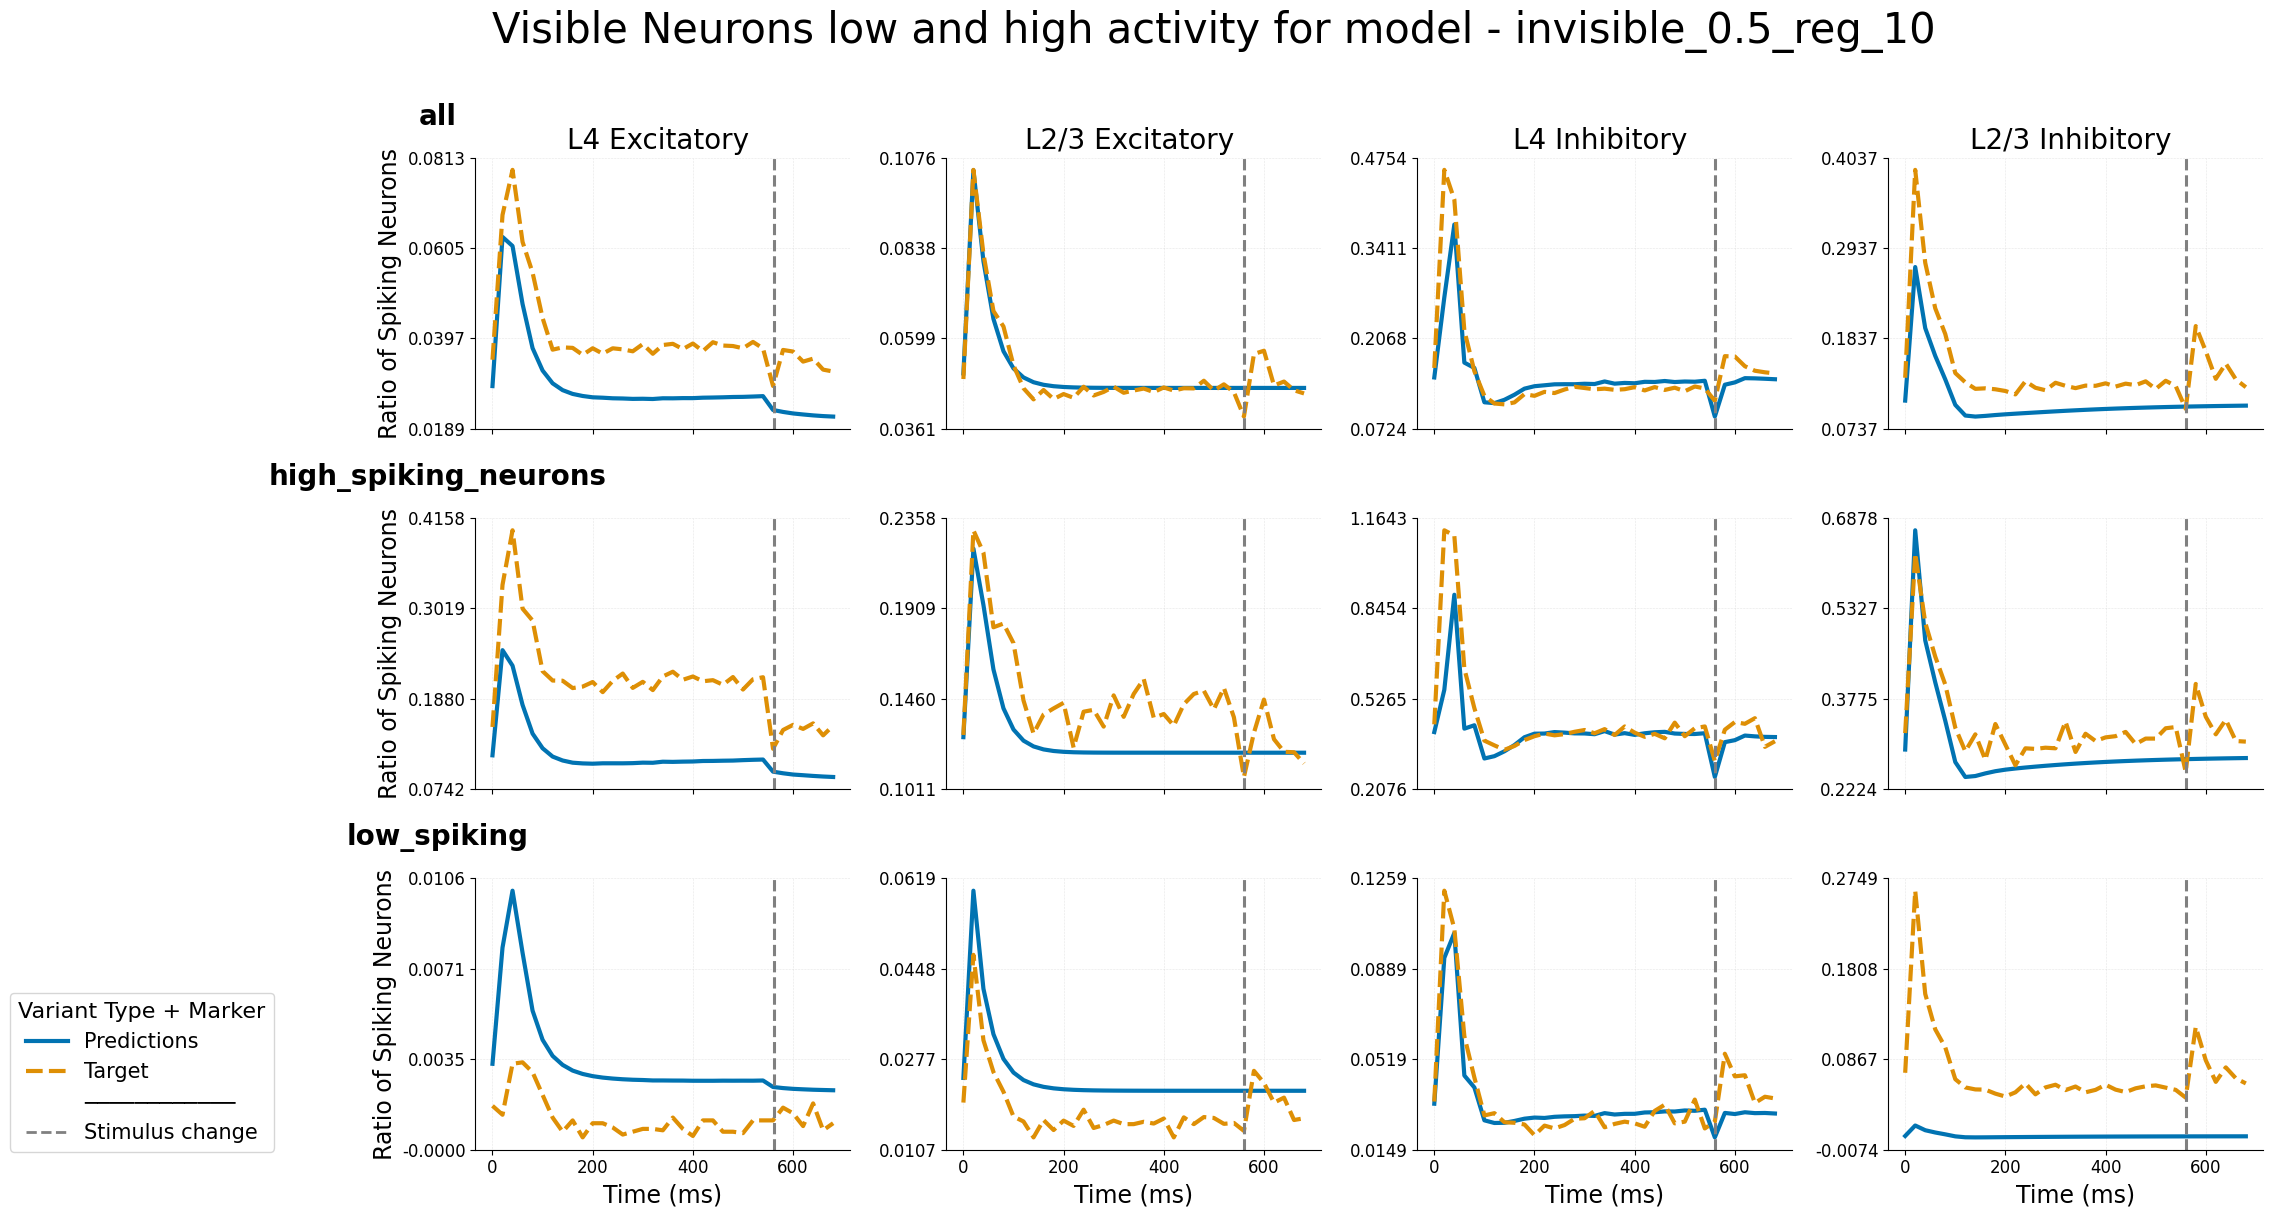

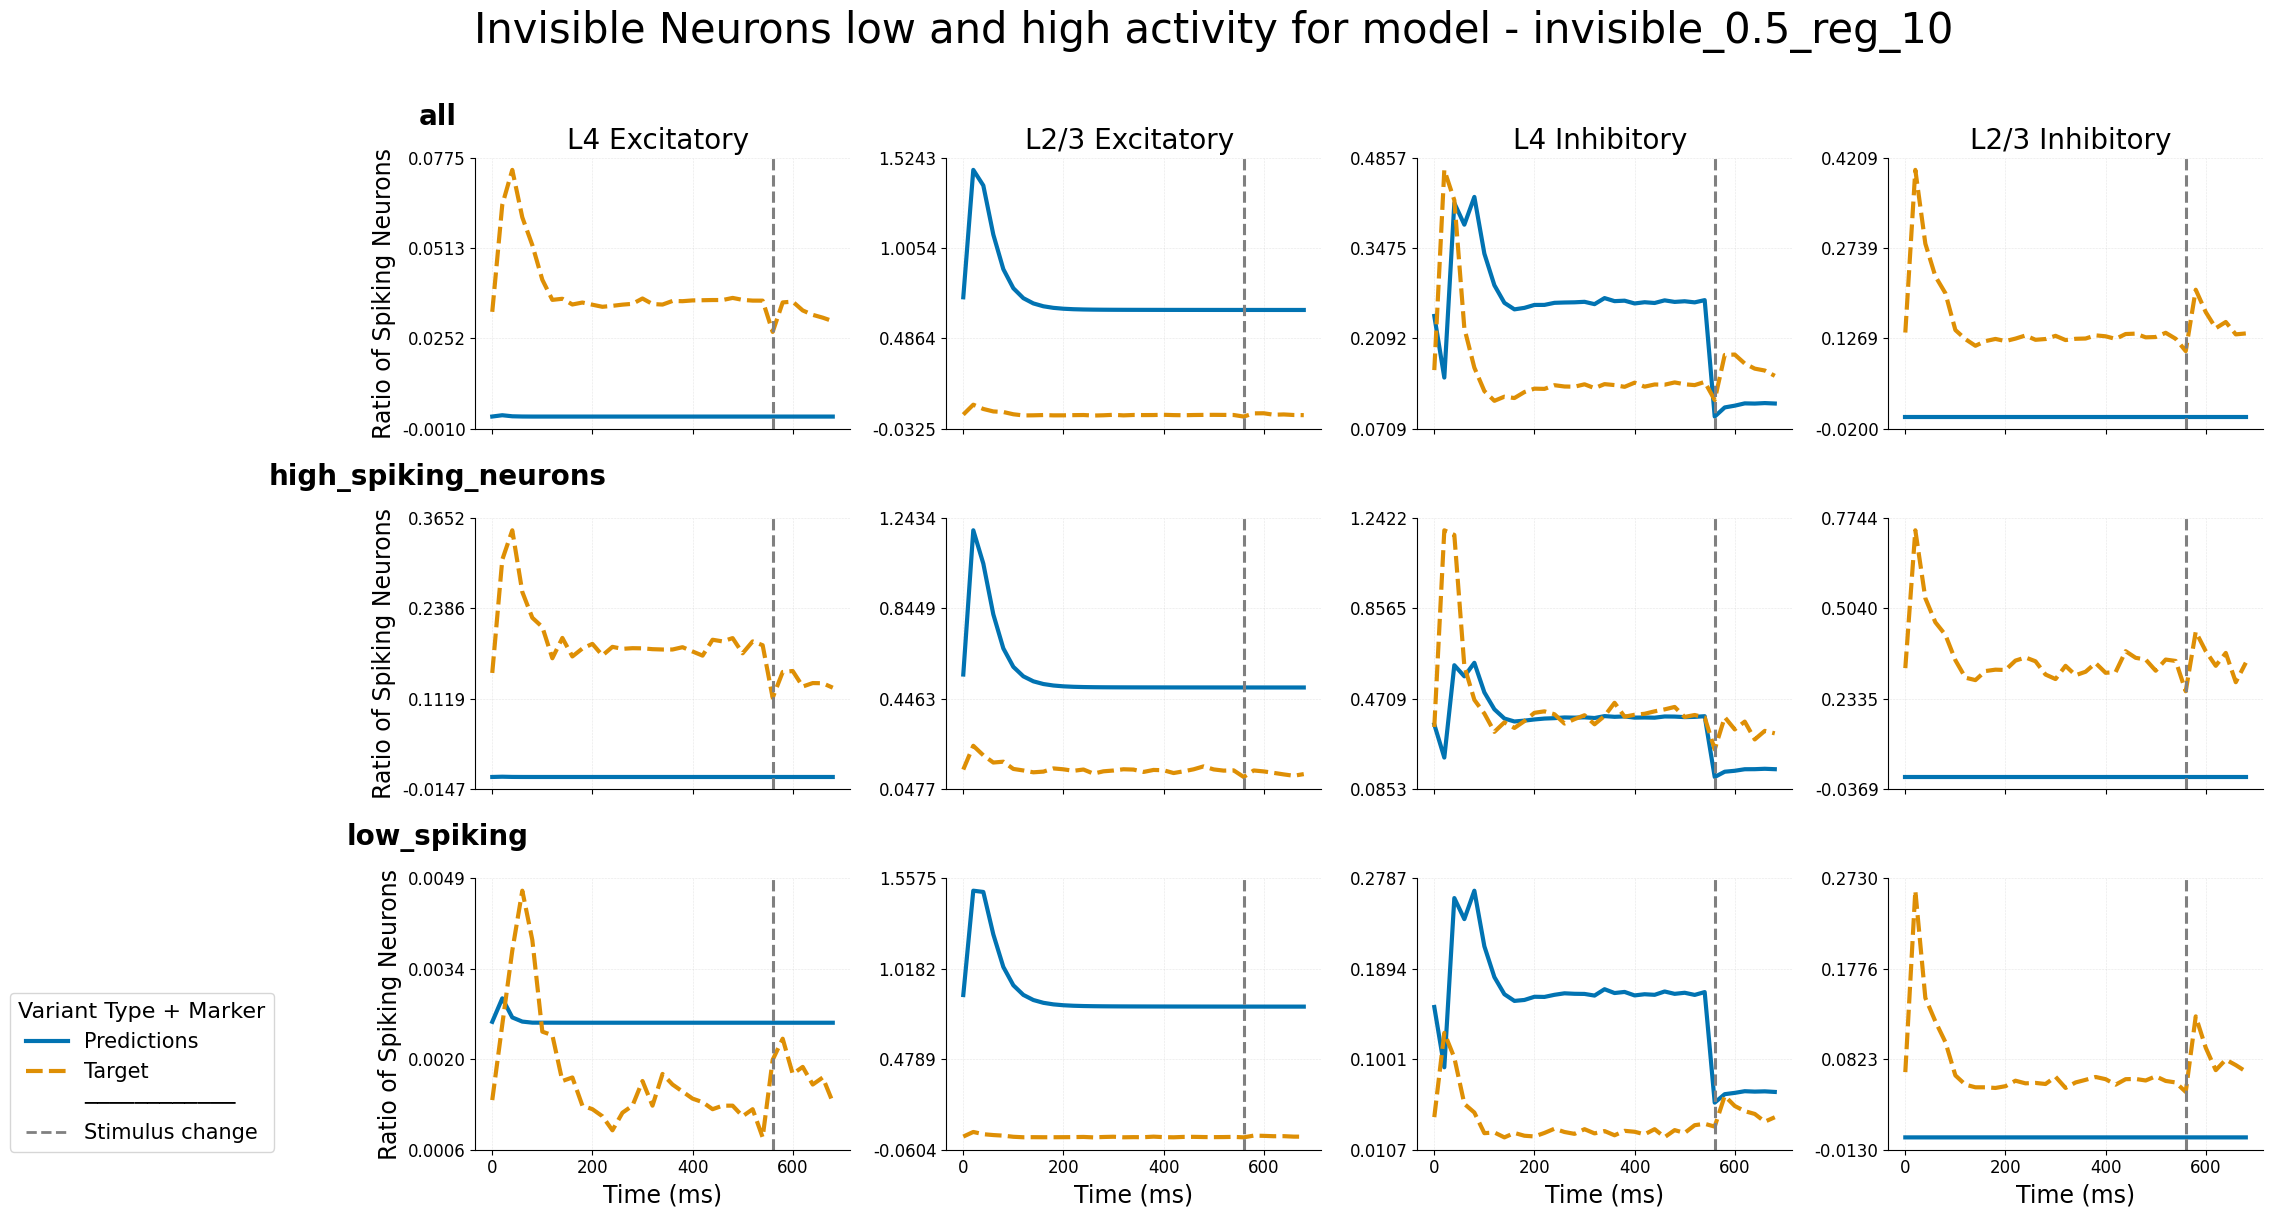

In [5]:
if visibility_processing:
    visible_df = df_spiking_ratios[df_spiking_ratios['visibility'] == VisibilityVariants.VISIBLE_NEURONS]
    invisible_df = df_spiking_ratios[df_spiking_ratios['visibility'] == VisibilityVariants.INVISIBLE_NEURONS]
    plot_comparison_synchrony_curves_across_layers(
        visible_df, 
        save_fig=f"plots/plot_high_low_activity_{model_variant}_visible.pdf", 
        title=f"Visible Neurons low and high activity for model - {model_variant}",
    )
    plot_comparison_synchrony_curves_across_layers(
        invisible_df, 
        save_fig=f"plots/plot_high_low_activity_{model_variant}_invisible.pdf", 
        title=f"Invisible Neurons low and high activity for model - {model_variant}"
    )
else:
    plot_comparison_synchrony_curves_across_layers(
        df_spiking_ratios, 
        save_fig=f"plots/plot_high_low_activity_{model_variant}.pdf",
        title=f"All neurons low and high activity for model - {model_variant}",)
